# Training DQN Agent on Snake using Jumanji API
This notebook is an example of how to use the Jumanji API to train a Deep-RL agent. We will train a [DQN](https://arxiv.org/abs/1312.5602) agent on the `"Snake-v1"` Jumanji environment under the Anakin framework. The Anakin design was developed by Matteo Hessel, Manuel Kroiss, Fabio Viola and Hado van Hasselt in [Podracer architectures for scalable Reinforcement Learning](https://arxiv.org/abs/2104.06272).

**Aims:**
* Understand the basics of the Jumanji API.
* Solve the `"Snake-v1"` environment with a DQN using the Anakin framework.

**Prerequisites:**
* Familiarity with [JAX](https://jax.readthedocs.io/en/latest/beginner_guide.html#beginner-guide).
* Familiarity with some Deep Reinforcement Learning algorithms. ([DQN Tutorial](https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc)) 

## Install and Import

In [ ]:
%%capture
! pip3 install -U pip

# if using a GPU
! pip install --upgrade "jax[cuda11_local]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# if using a TPU 
#! pip install jax[tpu] -f https://storage.googleapis.com/jax-releases/libtpu_releases.html # tpu

! pip install jaxlib
! pip3 install dm-haiku
! pip3 install optax 
! pip3 install matplotlib
! pip3 install jumanji
! pip3 install tensorflow
! pip3 install tensorrt
! pip3 install chex
! pip3 install rlax
! pip3 install tqdm
! pip3 install distrax

In [83]:
# ensure GPU is not preallocating space
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]='false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

import jax
import warnings

accelerator_type = jax.devices()[0].platform

if accelerator_type == 'tpu':
    # setup TPU
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
    print("Running with TPU!")

elif accelerator_type == "gpu":
    print("Running with GPU!")

else:
    print("Running with CPU!")
    warnings.warn(
        "Running with CPU. We reccomend running this notebook in Colab with TPU enabled,"
        "or GPU if TPU is not available."
    )

import jax.numpy as jnp
import jaxlib
from jax.lib import xla_bridge
from jax import lax
import tensorrt
import tensorflow as tf

import haiku as hk
import optax
import rlax
import distrax
import timeit
import chex

import numpy as np
import collections
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from typing import Sequence, Tuple, Callable, Any

import jumanji
from jumanji.wrappers import AutoResetWrapper
from jumanji.environments.routing.snake import State, Observation, Snake
from jumanji.types import TimeStep

# prevent TensorFlow from allocating GPU memory
tf.config.set_visible_devices([], "GPU")

# for VScode output
%matplotlib inline

Running with GPU!


## Basic usage of Jumanji
We implement a 10 step episode to illustrate the basic usage of a Jumanji environment. 

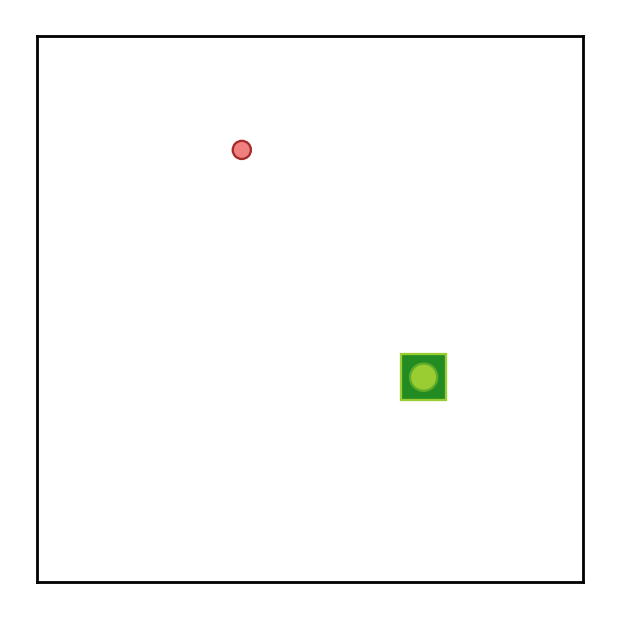

In [2]:
# initialise environment
env = jumanji.make("Snake-v1")
num_actions = env.action_spec().num_values

# generate PRNG key for randomness
key = jax.random.PRNGKey(0)

# reset the environment and receive the initial state and timestep
state, timestep = env.reset(key)

# jit environment step function
env_step = jax.jit(env.step)

# run episode for 10 steps
done = False
transitions = 0
while not done and transitions < 10:
    # generate new key
    key, _ = jax.random.split(key)

    # select action randomly
    action = jax.random.randint(key, (), 0, num_actions)

    # transition to next state
    state, timestep = env_step(state, action)
    transitions += 1

    # validate action
    done = not timestep.discount

    # render environment
    env.render(state)


## Deep Q-Network
Here, we define the DQN's architecture and get the `q_values` of some `dummy_observation`.

In [3]:
def build_dqn(
    num_outputs: int,
    mlp_units: Tuple[int] = (64, 64, 32),
    conv_n_channels: int = 32,
    time_limit: int = 5000,
):
    """Builds and returns Deep Q-Network"""

    def network_fn(observation: Observation) -> chex.Array:
        torso = hk.Sequential(
            [
                hk.Conv2D(conv_n_channels, (3, 3), 3),
                jax.nn.relu,
                hk.Conv2D(conv_n_channels, (2, 2), 2),
                jax.nn.relu,
                hk.Conv2D(conv_n_channels, (2, 2), 1),
                jax.nn.relu,
                hk.Flatten(),
            ]
        )
        flat = hk.Flatten(preserve_dims=-2)

        # convolve the grid and flatten the output
        embedding = flat(torso(observation.grid))

        # concatenate the embedding with the step count
        norm_step_count = jnp.expand_dims(observation.step_count / time_limit, axis=-1)
        embedding = jnp.concatenate((embedding, norm_step_count), axis=-1)

        # pass the embedding through an MLP
        head = hk.nets.MLP((*mlp_units, num_outputs), activate_final=False)

        if num_outputs == 1:
            value = jnp.squeeze(head(embedding), axis=-1)
            return value
        else:
            logits = head(embedding)
            logits = jnp.where(
                observation.action_mask, logits, jnp.finfo(jnp.float32).min
            )
            return logits

    return hk.without_apply_rng(hk.transform(network_fn))


# build DQN and get dummy q-values
DQN = build_dqn(num_outputs=num_actions)

# initial DQN with a dummy observation
initial_parameters = DQN.init(key, timestep.observation)

# jit apply method
model_apply = jax.jit(DQN.apply)

# get q_values
q_values = model_apply(initial_parameters, timestep.observation)

print(q_values)


[ 0.00207879 -0.00163817  0.00159139  0.00035977]


## Anakin Framework
The majority of the code below is copied verbatim from the [Podracer Architectures for Scalable RL](https://colab.research.google.com/drive/1974D-qP17fd5mLxy6QZv-ic4yxlPJp-G?usp=sharing#scrollTo=mGSmAiCHJsas).

**Additions**
* $\epsilon$-greedy action selection as apposed to a greedy selection
* Record metrics such as max and mean episode return per batch
* An evaluation step per batch

In [3]:
class TimeIt:
    def __init__(self, tag, frames=None):
        self.tag = tag
        self.frames = frames

    def __enter__(self):
        self.start = timeit.default_timer()
        return self

    def __exit__(self, *args):
        self.elapsed_secs = timeit.default_timer() - self.start
        msg = self.tag + (": Elapsed time=%.2fs" % self.elapsed_secs)
        if self.frames:
            msg += ", FPS=%.2e" % (self.frames / self.elapsed_secs)
        print(msg)


@chex.dataclass(frozen=True)
class Experience:
    q_values: chex.Array
    action: chex.Array
    discount: chex.Array
    reward: chex.Array
    next_q_values: chex.Array


@chex.dataclass(frozen=True)
class EpisodeMetrics:
    """Metrics that we use to keep track of the episode return and length
    throughout interation with the environment."""

    episode_return: chex.Array
    episode_length: chex.Array


@chex.dataclass(frozen=True)
class Parameters:
    main: hk.Params
    target: hk.Params


@chex.dataclass(frozen=True)
class LearningState:
    update_count: chex.Array
    update_every: chex.Array


In [291]:
def get_evaluator(
    forward_pass: Callable,
    eval_env_reset: Callable,
    eval_env_step: Callable,
    key: chex.PRNGKey,
    eval_batch_size: int = 5,
):
    """Returns method to evaluate currently policy"""

    def evaluate(params: hk.Params):
        def evaluate_one_episode(key: chex.PRNGKey):
            def one_step(
                state: State,
                timestep: TimeStep,
                return_: chex.Numeric,
            ):
                action = jnp.argmax(
                    forward_pass(params, expand_obs_dims(timestep.observation))[0]
                )
                state, timestep = eval_env_step(state, action)
                return_ += timestep.reward
                return state, timestep, return_

            # reset environment and execute a single episode
            key, _ = jax.random.split(key)
            state, timestep = eval_env_reset(key)
            *_, return_ = jax.lax.while_loop(
                lambda carry: ~carry[1].last(),
                lambda carry: one_step(*carry),
                (state, timestep, jnp.array(0, float)),
            )
            return return_

        # vmap to evaluate over batch of episodes
        keys = jax.random.split(key, eval_batch_size)
        returns = jax.vmap(evaluate_one_episode)(keys)
        return jnp.mean(returns)

    return evaluate


def soft_target_update(main_params, target_params, tau=3e-3):
    for layer in main_params:
        for p in main_params[layer]:
            target_params[layer][p] = tau*main_params[layer][p] + (1-tau)*target_params[layer][p]

    return target_params



def update_target(parameters: Parameters, learn_state: LearningState):
    target = jax.lax.cond(
        jax.numpy.mod(learn_state.update_count, learn_state.update_every) == 0,
        soft_target_update,
        lambda x, y: y,
        parameters.main,
        parameters.target,
    )
    return Parameters(main=parameters.main, target=target)


def expand_obs_dims(observation: Observation, axis=0):
    expand = lambda x: jnp.expand_dims(x, axis=axis)
    new_observation = jax.tree_util.tree_map(expand, observation)

    return new_observation


Define useful containers.

### Define Learner Function

The method `get_learner_fn` returns a method `learner_fn` which:
* Collects a batch of experiences from a trajectory while recording any useful information. 
* Computes the squared TD($\lambda$) loss of the batch of experiences.
* Computes the gradient of the loss with respect to the network's parameters.
* Aggregates the gradient across a batch of trajectories, and across multiple devices (if using TPU).
* Updates the network's parameters with the Adam optimizer.
* Runs this update step multiple times without going back to python. The original Anakin implementation uses `jax.lax.fori` however we would like to obtain information from each step of the algoirthm. Therefore, we use `jax.lax.scan`.

In [232]:
def get_learner_fn(
    env_step: Callable,
    forward_pass: Callable,
    opt_update: Callable,
    rollout_len: int,
    agent_discount: float,
    iterations: int,
    epsilon_decay: int,
):
    """Define the minimal unit of computation in Anakin."""

    def loss_fn(
        main_params: hk.Params,
        target_params: hk.Params,
        outer_key: chex.PRNGKey,
        env_state: State,
        env_timestep: TimeStep,
        episode_metrics: EpisodeMetrics,
        epsilon: float,
    ):
        """Compute the loss on a single trajectory."""

        def step_fn(carry, key: chex.PRNGKey):
            env_state, env_timestep, episode_metrics, epsilon = carry

            q_values = forward_pass(
                main_params, expand_obs_dims(env_timestep.observation)
            )[0]
            action = distrax.EpsilonGreedy(q_values, epsilon).sample(seed=key)
            next_env_state, next_env_timestep = env_step(env_state, action)
            reward = next_env_timestep.reward
            discount = next_env_timestep.discount
            next_q_values = forward_pass(
                target_params, expand_obs_dims(next_env_timestep.observation)
            )[0]

            info = {
                "episode_return": jnp.where(
                    discount == 0.0, reward + episode_metrics.episode_return, jnp.nan
                ),
                "episode_length": jnp.where(
                    discount == 0.0, 1 + episode_metrics.episode_length, jnp.nan
                ),
            }

            episode_metrics = EpisodeMetrics(
                episode_return=jnp.where(
                    discount == 0.0,
                    jnp.array(0.0),
                    reward + episode_metrics.episode_return,
                ),
                episode_length=jnp.where(
                    discount == 0.0, jnp.array(0), 1 + episode_metrics.episode_length
                ),
            )

            carry = next_env_state, next_env_timestep, episode_metrics, epsilon
            return carry, (
                Experience(
                    q_values=q_values,
                    action=action,
                    discount=discount,
                    reward=reward,
                    next_q_values=next_q_values,
                ),
                info,
            )

        # trajectory
        step_keys = jax.random.split(outer_key, rollout_len)
        (env_state, env_timestep, episode_metrics, epsilon), (rollout, info) = lax.scan(
            step_fn, (env_state, env_timestep, episode_metrics, epsilon), step_keys
        )

        qa_tm1 = rlax.batched_index(rollout.q_values[:-1], rollout.action[:-1])

        batched_dql = jax.vmap(rlax.double_q_learning)

        error = batched_dql(
            q_tm1=rollout.q_values[:-1],
            a_tm1=rollout.action[:-1],
            r_t=rollout.reward[1:],
            discount_t=rollout.discount[1:],
            q_t_value=rollout.next_q_values[:-1],
            q_t_selector=rollout.q_values[1:],
        )

        loss = jnp.mean(error**2)

        # log info
        info = {
            "episode_return": jnp.nanmean(info["episode_return"], axis=0),
            "episode_length": jnp.nanmean(info["episode_length"], axis=0),
            "reward": jnp.mean(rollout.reward),
            "q_values": jnp.mean(qa_tm1),
            "max_episode_return": jnp.nanmax(info["episode_return"], axis=0),
            "loss": jnp.array([loss]),
        }

        return loss, (env_state, env_timestep, episode_metrics, info)

    def update_fn(
        parameters: Parameters,
        opt_state: Tuple,
        key: chex.PRNGKey,
        env_state: State,
        env_timestep: TimeStep,
        episode_metrics: EpisodeMetrics,
        epsilon: float,
    ):
        """Compute a gradient update from a single trajectory."""

        # compute grad for single trajectory
        key, loss_key = jax.random.split(key)

        grads, (
            new_env_state,
            new_env_timestep,
            episode_metrics,
            info,
        ) = jax.grad(loss_fn, has_aux=True)(
            parameters.main,
            jax.lax.stop_gradient(parameters.target),
            loss_key,
            env_state,
            env_timestep,
            episode_metrics,
            epsilon,
        )

        # reduce mean across cores and batch
        grads = lax.pmean(grads, axis_name="j")
        grads = lax.pmean(grads, axis_name="i")

        # transform grads
        updates, new_opt_state = opt_update(grads, opt_state)

        # update parameters
        new_params = optax.apply_updates(parameters.main, updates)

        new_parameters = Parameters(main=new_params, target=parameters.target)

        return (
            new_parameters,
            new_opt_state,
            key,
            new_env_state,
            new_env_timestep,
            episode_metrics,
            info,
        )

    def learner_fn(
        parameters: Parameters,
        opt_state: Tuple,
        learn_state: LearningState,
        keys: chex.PRNGKey,
        env_states: State,
        env_timesteps: TimeStep,
        episode_metrics: EpisodeMetrics,
        epsilon: float,
    ):
        """Vectorise and repeat the update."""
        # vectorize across batch
        batched_update_fn = jax.vmap(update_fn, axis_name="j")

        def iterate_fn(carry, _):
            (
                parameters,
                opt_state,
                learn_state,
                keys,
                env_states,
                env_timesteps,
                episode_metrics,
                epsilon,
            ) = carry

            epsilon = epsilon*epsilon_decay

            (
                new_parameters,
                new_opt_state,
                keys,
                new_env_state,
                new_env_timestep,
                episode_metrics,
                info,
            ) = batched_update_fn(
                parameters,
                opt_state,
                keys,
                env_states,
                env_timesteps,
                episode_metrics,
                epsilon,
            )

            learn_state = LearningState(
                update_count=learn_state.update_count + 1,
                update_every=learn_state.update_every,
            )

            new_parameters = update_target(new_parameters, learn_state)

            carry = (
                new_parameters,
                new_opt_state,
                learn_state,
                keys,
                new_env_state,
                new_env_timestep,
                episode_metrics,
                epsilon,
            )

            # update info
            max_return_info = {
                "max_episode_return": jnp.nanmax(info["max_episode_return"], axis=0)
            }

            info = jax.tree_util.tree_map(lambda x: jnp.nanmean(x, axis=0), info)
            info.update(max_return_info)

            return carry, info

        init = (
            parameters,
            opt_state,
            learn_state,
            keys,
            env_states,
            env_timesteps,
            episode_metrics,
            epsilon,
        )

        return jax.lax.scan(iterate_fn, init, xs=None, length=iterations)

    return learner_fn


### Define experiment

Given a set of hyper-parameters, `run_experiment` initialises and executes the experiment. The experiement runs multiped pmapped iterations of `learner_fn` until the desired number of total training iterations is reached. `run_experiment` returns the recorded training information and the most recently updated network parameters.

In [44]:
def run_experiment(
    env,
    eval_env,
    batch_size: int,
    rollout_len: int,
    step_size: float,
    iterations: int,
    discount_factor: float,
    epsilon_min: float,
    epsilon_decay_period: float,
    update_target_every: int,
    seed: int,
):
    """Runs experiment"""

    # generate prng keys
    key, env_key, param_key, eval_key = jax.random.split(
        jax.random.PRNGKey(seed), num=4
    )

    # get available TPU cores
    cores_count = len(jax.devices())

    # define network
    network = build_dqn(env.action_spec().num_values)

    # get dummy observation to initialise network parameters
    _, d_timestep = env.reset(env_key)
    dummy_obs = d_timestep.observation
    params = network.init(param_key, expand_obs_dims(dummy_obs))

    parameters = Parameters(main=params, target=params)

    # define and initialise optimiser
    optim = optax.adam(step_size)
    opt_state = optim.init(parameters.main)

    epsilon = jnp.array([1.])

    inner_iter_length = 100

    # jitables
    env_step = jax.jit(env.step)
    model_apply = network.apply
    eval_env_reset = jax.jit(eval_env.reset)
    eval_env_step = jax.jit(eval_env.step)

    # get learner method
    learn = get_learner_fn(
        env_step=env_step,
        forward_pass=model_apply,
        opt_update=optim.update,
        rollout_len=rollout_len,
        agent_discount=discount_factor,
        iterations=inner_iter_length,
        epsilon_decay=(epsilon_min/epsilon)**(1/(iterations*epsilon_decay_period))
    )

    # replicate over multiple cores
    learn = jax.pmap(learn, axis_name="i")

    # get evaluation method
    evaluate = jax.jit(
        get_evaluator(
            forward_pass=model_apply,
            eval_env_reset=eval_env_reset,
            eval_env_step=eval_env_step,
            key=eval_key,
        )
    )

    # define episode metrics
    episode_metrics = EpisodeMetrics(
        episode_return=jnp.zeros(shape=(), dtype=jnp.float32),
        episode_length=jnp.zeros(shape=(), dtype=jnp.int16),
    )

    learn_state = LearningState(
        update_count=jnp.array([0]), update_every=jnp.array([update_target_every])
    )

    

    # broadcast to cores and batch
    broadcast = lambda x: jnp.broadcast_to(x, (cores_count, batch_size) + x.shape)

    opt_state = jax.tree_map(broadcast, opt_state)
    parameters = jax.tree_map(broadcast, parameters)
    episode_metrics = jax.tree_map(broadcast, episode_metrics)
    epsilon = jax.tree_map(broadcast, epsilon)

    # get intial states
    key, *env_keys = jax.random.split(key, cores_count * batch_size + 1)
    env_states, env_timesteps = jax.vmap(env.reset)(jnp.stack(env_keys))

    key, *step_keys = jax.random.split(key, cores_count * batch_size + 1)

    reshape = lambda x: jax.tree_util.tree_map(
        lambda x: x.reshape((cores_count, batch_size) + x.shape[1:]), x
    )

    # add dimension to pmap over
    step_keys = reshape(jnp.stack(step_keys))
    env_states = reshape(env_states)
    env_timesteps = reshape(env_timesteps)

    # compile
    num_frames_compile = cores_count * inner_iter_length * rollout_len * batch_size
    with TimeIt(tag="COMPILATION", frames=num_frames_compile):
        learn(
            parameters,
            opt_state,
            learn_state,
            step_keys,
            env_states,
            env_timesteps,
            episode_metrics,
            epsilon,
        )

    # execute mulitple training iterations
    num_frames = cores_count * iterations * rollout_len * batch_size
    n_outer_iter = int(iterations // inner_iter_length)
    with TimeIt(tag="EXECUTION", frames=num_frames):
        for i in tqdm(range(n_outer_iter)):
            (
                parameters,
                opt_state,
                learn_state,
                step_keys,
                env_states,
                env_timesteps,
                episode_metrics,
                epsilon, 
            ), new_info = learn(
                parameters,
                opt_state,
                learn_state,
                step_keys,
                env_states,
                env_timesteps,
                episode_metrics,
                epsilon,
            )


            # update info
            max_return_info = {
                "max_episode_return": jnp.nanmax(new_info["max_episode_return"], axis=0)
            }

            new_info = jax.tree_util.tree_map(
                lambda x: jnp.nanmean(x, axis=0), new_info
            )
            new_info.update(max_return_info)

            # evaluate and add to info
            params_single_device = jax.tree_util.tree_map(
                lambda x: x[0, 0], parameters.main
            )

            eval_return = evaluate(params_single_device)

            additional_info = {
                "eval_return": jnp.array([eval_return]),
                "epsilon": epsilon[0][0]
            }
            new_info.update(additional_info)

            if i == 0:
                info = new_info
            else:
                info = {
                    dict_key: jnp.concatenate((info[dict_key], new_info[dict_key]))
                    for dict_key in info.keys()
                }

    params_single_device = jax.tree_util.tree_map(lambda x: x[0, 0], parameters.main)
    return info, params_single_device


#### Snake 6x6

In [214]:
def build_dqn(
    num_outputs: int,
    mlp_units: Tuple[int] = (64, 64),
    conv_n_channels: int = 8,
    time_limit: int = 500,
):
    """Builds and returns Deep Q-Network"""

    def network_fn(observation: Observation) -> chex.Array:
        torso = hk.Sequential(
            [
                hk.Conv2D(conv_n_channels, (2, 2), 2),
                jax.nn.relu,
                hk.Conv2D(conv_n_channels, (2, 2), 1),
                jax.nn.relu,
                hk.Flatten(),
            ]
        )
        # convolve the grid and flatten the output
        embedding = torso(observation.grid)

        # concatenate the embedding with the step count
        norm_step_count = jnp.expand_dims(observation.step_count / time_limit, axis=-1)
        embedding = jnp.concatenate((embedding, norm_step_count), axis=-1)

        # pass the embedding through an MLP
        head = hk.nets.MLP((*mlp_units, num_outputs), activate_final=False)

        if num_outputs == 1:
            value = jnp.squeeze(head(embedding), axis=-1)
            return value
        else:
            logits = head(embedding)
            logits = jnp.where(
                observation.action_mask, logits, jnp.finfo(jnp.float32).min
            )
            return logits

    return hk.without_apply_rng(hk.transform(network_fn))


env = Snake(num_rows=6, num_cols=6, time_limit=500)
key = jax.random.PRNGKey(0)
_, timestep = env.reset(key)

# build DQN and get dummy q-values
DQN = build_dqn(num_outputs=env.action_spec().num_values)

# initial DQN with a dummy observation
initial_parameters = DQN.init(key, expand_obs_dims(timestep.observation, axis=0))

# jit apply method
model_apply = jax.jit(DQN.apply)

# get q_values
q_values = model_apply(
    initial_parameters, expand_obs_dims(timestep.observation, axis=0)
)

print(q_values)


[[ 1.0305612e-02  7.8526780e-02 -3.4028235e+38  3.1917792e-02]]


In [292]:
from jumanji.environments import Snake

env = AutoResetWrapper(Snake(num_rows=6, num_cols=6, time_limit=500))
eval_env = Snake(num_rows=6, num_cols=6, time_limit=500)


info, params = run_experiment(
    env,
    eval_env,
    batch_size=128,
    rollout_len=2,
    step_size=1e-4,
    iterations=20_000,
    discount_factor=0.997,
    epsilon_min=0.1,
    epsilon_decay_period=1,
    update_target_every=750,
    seed=0,
)


COMPILATION: Elapsed time=4.13s, FPS=6.20e+03


 75%|███████▌  | 150/200 [00:39<00:13,  3.84it/s]

### Run Experiment and Visualise Results 
We first choose our set of hyper-parameters and call `run_experiment`.

In [ ]:
# env = AutoResetWrapper(jumanji.make("Snake-v1"))
# eval_env = jumanji.make("Snake-v1")

# info, params = run_experiment(
#     env,
#     eval_env,
#     batch_size=256,
#     rollout_len=20,
#     step_size=2e-4,
#     iterations=20_000,
#     discount_factor=0.997,
#     epsilon=0.02,
#     seed=0,
# )


#### Plot Results

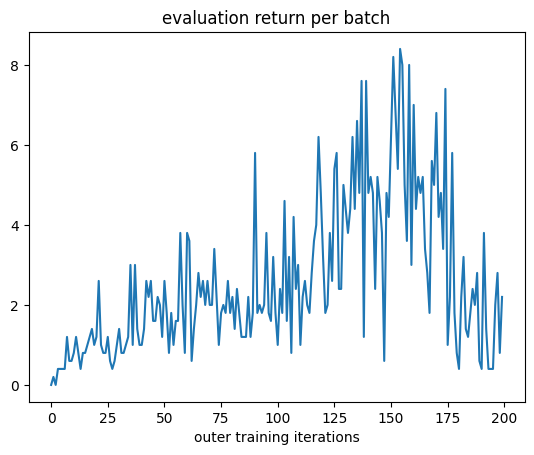

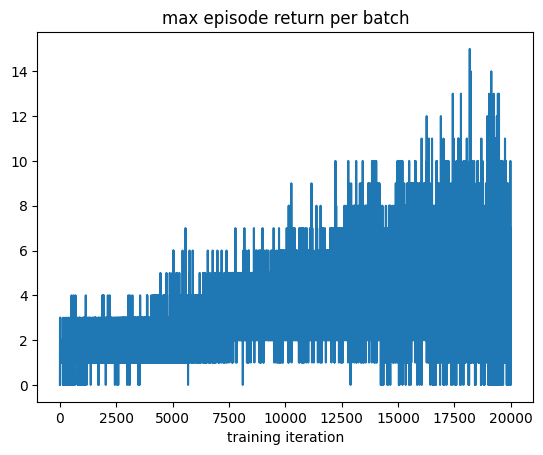

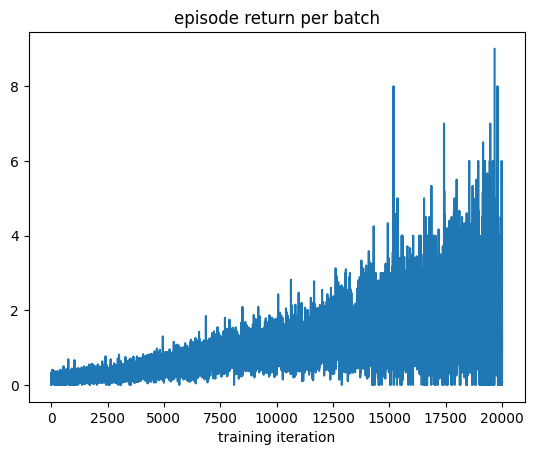

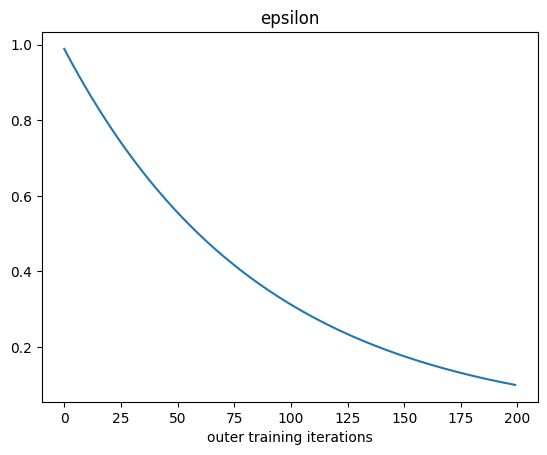

In [290]:
plt.plot(info["eval_return"])
plt.title("evaluation return per batch")
plt.xlabel("outer training iterations")
plt.show()

plt.plot(info["max_episode_return"])
plt.title("max episode return per batch")
plt.xlabel("training iteration")
plt.show()

plt.plot(info["episode_return"])
plt.title("episode return per batch")
plt.xlabel("training iteration")
plt.show()

plt.plot(info["epsilon"])
plt.title("epsilon")
plt.xlabel("outer training iterations")
plt.show()

## Rollout Agent
We let the agent act greedily throughout an episode and visualise its behaviour.


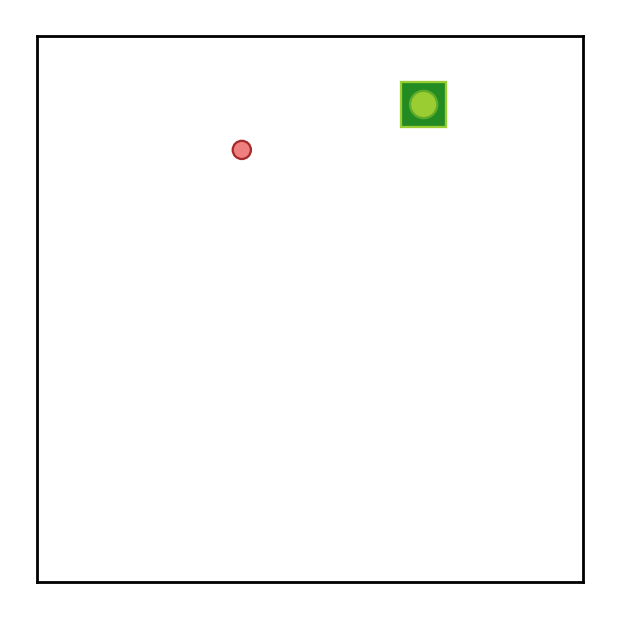

In [ ]:
key = jax.random.PRNGKey(0)

env = jumanji.make("Snake-v1")
state, timestep = env.reset(key)
env_step = jax.jit(env.step)

DQN = build_dqn(env.action_spec().num_values)
initial_parameters = DQN.init(key, timestep.observation)
policy = jax.jit(DQN.apply)

done = False
transitions = 0
while not done and transitions < 10:
    # select action greedily
    action = jnp.argmax(policy(params, timestep.observation))

    # take a step in the environment
    state, timestep = env_step(state, action)
    transitions += 1

    done = not timestep.discount

    env.render(state)


## Conclusion

This notebook serves as an illustrative example of the Jumanji API's functionality. Its purpose is to provide an overview of the API's basic usage, demonstrate the training of a DQN agent using the Anakin Framework, and visualise a single episode's rollout. We hope this has been a valuable resource in acquainting you with the fundamentals of the Jumanji API. For a detailed understanding of the Jumanji API's capabilities and features, we invite you to take a look at the official [Jumanji documentation](https://instadeepai.github.io/jumanji/).

Goodluck with any of your research endeavours and don't forget to cite the library using:

```
@software{jumanji2023github,
  author = {Clément Bonnet and Daniel Luo and Donal Byrne and Sasha Abramowitz
        and Vincent Coyette and Paul Duckworth and Daniel Furelos-Blanco and
        Nathan Grinsztajn and Tristan Kalloniatis and Victor Le and Omayma Mahjoub
        and Laurence Midgley and Shikha Surana and Cemlyn Waters and Alexandre Laterre},
  title = {Jumanji: a Suite of Diverse and Challenging Reinforcement Learning Environments in JAX},
  url = {https://github.com/instadeepai/jumanji},
  version = {0.2.2},
  year = {2023},
}
```
